In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!nvidia-smi

Sun Sep 20 02:39:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
! pip install --upgrade numpy pandas tqdm torch catalyst==20.09

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.2)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.49.0)
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: catalyst==20.09 in /usr/local/lib/python3.6/dist-packages (20.9)


In [15]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

# GPU hack if you need
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Data

Columns
- `party_rk` – client unique identifier
- `account_rk` – client account unique identifier
- `financial_account_type_cd` – debit/credit card flag
- `transaction_dttm` – operation datetime
- `transaction_type_desc` – purchase/payment/...
- `transaction_amt_rur` – transaction price
- `merchant_type` - DUTY FREE STORES/FUEL DEALERS/RESTAURANTS/ etc
- `merchant_group_rk` - McDonald's/Wildberries/ etc

It's important that table is already sorted by `transaction_dttm` column!!!

In [16]:
DATADIR = r"/content/drive/My Drive/tinkoff_2/hackathon_data"

In [17]:
transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"
transactions_enhanced_path = f"{DATADIR}/avk_hackathon_data_trans_socdem_products_balance_encoded.csv"
# transactions_df = pd.read_csv(transactions_path)
# print(transactions_df.shape)
# transactions_df.iloc[500:520]

In [ ]:
transactions_df.sort_values('transaction_amt_rur', ascending=False).head(20)

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
11305825,8864,8064,2,2019-12-19,Платеж,20000100.00,362481.0,1.0,NaN,NaN
10337120,8864,29751,2,2019-11-28,Платеж,12794540.00,825320.0,1.0,NaN,NaN
10280765,8864,29751,2,2019-11-20,Платеж,12754700.00,825320.0,1.0,NaN,NaN
11573153,8864,8064,2,2019-12-20,Оплата услуг,11519300.00,1449700.0,2.0,NaN,NaN
8657969,8864,8064,2,2019-09-30,Платеж,11000100.00,362481.0,1.0,NaN,NaN
2134332,44285,45289,2,2019-02-15,Платеж,11000100.00,825899.0,1.0,NaN,NaN
4310703,8864,29751,2,2019-06-05,Платеж,10751731.00,825320.0,1.0,NaN,NaN
36261,2646,2085,2,2019-01-20,Платеж,9949735.00,1175590.0,1.0,NaN,NaN
6315631,14956,104902,2,2019-08-12,Платеж,9240100.00,826957.0,1.0,NaN,NaN
6296885,14956,109628,2,2019-08-13,Платеж,9200100.00,2301710.0,1.0,NaN,NaN


In [ ]:
transactions_df.isna().sum()

party_rk                           0
account_rk                         0
financial_account_type_cd          0
transaction_dttm                   0
transaction_type_desc              0
transaction_amt_rur                6
merchant_rk                      976
merchant_type                   1665
merchant_group_rk            6223963
category                     1881017
dtype: int64

,account_rk
count,50000.000000
mean,1.331660
std,0.662926
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,11.000000


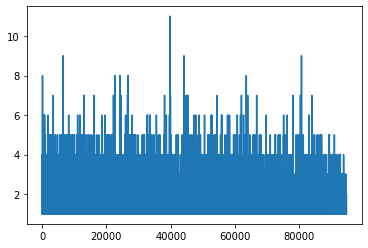

In [ ]:
tmp_df = transactions_df[['party_rk', 'account_rk']].groupby('party_rk').nunique()
plt.plot(tmp_df.index, tmp_df)
tmp_df.describe()

2.0302016205069404


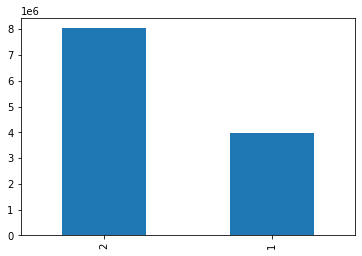

In [ ]:
tmp_df = transactions_df['financial_account_type_cd'].value_counts()
print(tmp_df[2]/tmp_df[1])
tmp_df.plot(kind='bar')

2019-01-01 00:00:00 2019-01-02 00:00:00 ... 2019-12-31 00:00:00


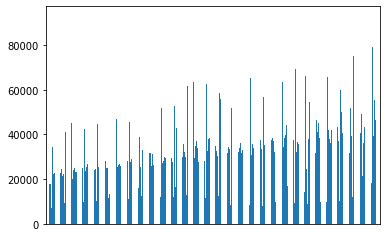

In [ ]:
tmp_df = transactions_df['transaction_dttm'].value_counts()
tmp_df.index = tmp_df.index.map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
tmp_df.sort_index(inplace=True)
tmp_df.plot(kind='bar')
plt.gca().set_xticks([])
print(tmp_df.index[0], tmp_df.index[1], '...', tmp_df.index[-1])

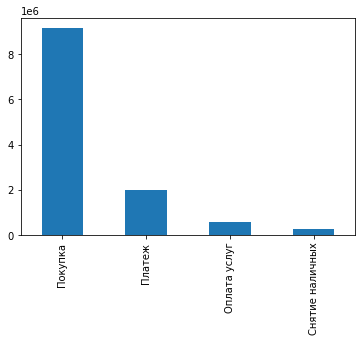

In [ ]:
transactions_df['transaction_type_desc'].value_counts().plot(kind='bar')

391.0 3186.888401838067


(-10.0, 25000.0)

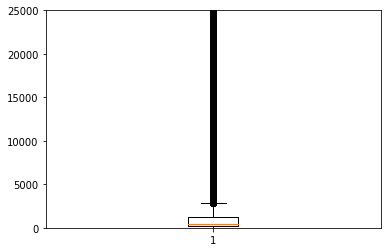

In [ ]:
tmp_df = transactions_df['transaction_amt_rur'].dropna()

print(tmp_df.median(), tmp_df.mean())
plt.boxplot(tmp_df)
plt.ylim([-10, 25000])

count    1.198595e+07
mean     2.666716e+02
std      1.215151e+02
min      1.000000e+00
25%      2.750000e+02
50%      2.860000e+02
75%      3.300000e+02
max      4.980000e+02
Name: merchant_type, dtype: float64

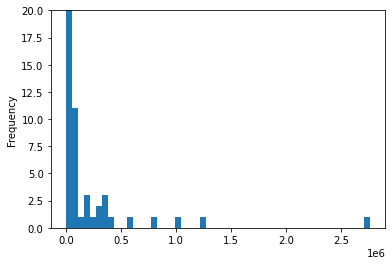

In [ ]:
tmp_df = transactions_df['merchant_type'].dropna()
tmp_df.value_counts().plot(kind='hist', bins=50)
plt.ylim([0, 20])
tmp_df.describe()

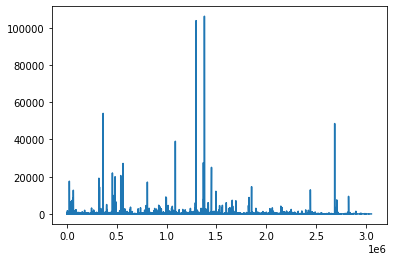

In [ ]:
tmp_df = transactions_df[['merchant_rk', 'merchant_group_rk']].groupby('merchant_rk').count()
plt.plot(tmp_df.index, tmp_df)

count    3.600000e+01
mean     2.807389e+05
std      6.761545e+05
min      1.872000e+03
25%      3.004575e+04
50%      5.550750e+04
75%      2.692645e+05
max      3.938925e+06
Name: category, dtype: float64

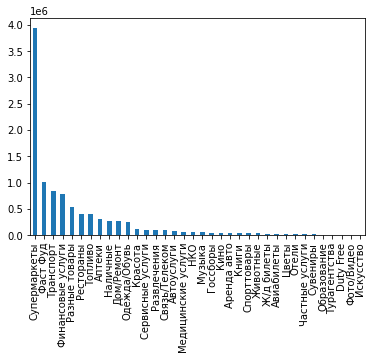

In [ ]:
tmp_df = transactions_df['category'].value_counts()
tmp_df.plot(kind='bar')
tmp_df.describe()

In [ ]:
story_texts_path = f"{DATADIR}/avk_hackathon_data_story_texts.csv"
story_texts_df = pd.read_csv(story_texts_path)
print(story_texts_df.shape)
story_texts_df.head()

(1631, 3)


,story_id,name,story_text
0,794,Профессия: свадебный организатор,"["""",""Как стать свадебным организатором"",""Это Л..."
1,821,Бизнес: магазин электроники,"["""",""Как открыть интернет-магазин электроники""..."
2,824,Как у них: Сингапур,"["""",""Жизнь в Сингапуре"",""Это Славина. Вместе с..."
3,839,Студии йоги,"["""",""Студии йоги"",""7 московских студий, где мо..."
4,848,Как получать больше кэшбэка,"["""",""Как получать больше кэшбэка"",""Подключите ..."


In [ ]:
story_texts_df['story_text'].iloc[0]

'["","Как стать свадебным организатором","Это Люба. Ей понравилось организовывать свою свадьбу, и\xa0она бросила работу юристом, чтобы\xa0стать свадебным организатором.","Свадебный организатор — это такая «точка сборки» для\xa0свадьбы. Он делает так, чтобы\xa0всё нужное на\xa0свадьбу приехало, все хорошо провели время, а\xa0потом уехали по\xa0домам, а\xa0не\xa0в\xa0больницы.","Одни организаторы работают сами по\xa0себе и\xa0получают клиентов через\xa0знакомых. Другие открывают агентства, в\xa0которых работают несколько организаторов.","Чтобы набраться опыта, присмотреть себе помощников и\xa0познакомиться с\xa0подрядчиками, Люба потратила 48\xa0000\xa0₽ на\xa0обучение в\xa0свадебных агентствах. ","У свадебного организатора ненормированный график. В\xa0день торжества Люба уходит с\xa0площадки последней, когда\xa0демонтировали всё оборудование и\xa0уехала даже\xa0уборщица.","Больше чем за\xa0год работы Люба провела 15\xa0свадеб с\xa0бюджетами от\xa0200\xa0000\xa0₽ до\xa01\xa0млн\xa0₽. Сва

In [ ]:
story_logs_path = f"{DATADIR}/avk_hackathon_data_story_logs.csv"
story_logs_df = pd.read_csv(story_logs_path)
print(story_logs_df.shape)
story_logs_df.head()

(13820, 5)


,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


In [ ]:
story_logs_df.isna().sum()

party_rk     0
date_time    0
story_id     0
category     0
event        0
dtype: int64

like        5920
favorite    5028
dislike      763
14]          592
77]          551
153          208
180          108
177           99
176           72
54]           54
19]           53
174           49
175           48
164           48
48            45
160           38
163           33
161           31
170           25
159           18
101]          14
182            9
76             6
102]           5
55]            2
173            1
Name: event, dtype: int64


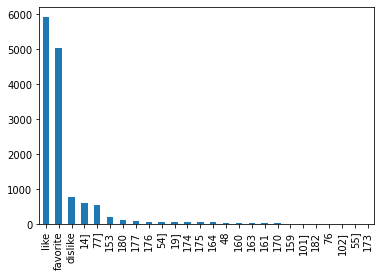

In [ ]:
tmp_df = story_logs_df['event'].value_counts()
print(tmp_df)
tmp_df.plot(kind='bar')

81    2392
71    1148
39     826
51     689
44     674
      ... 
77       1
23       1
56       1
79       1
75       1
Name: category, Length: 81, dtype: int64


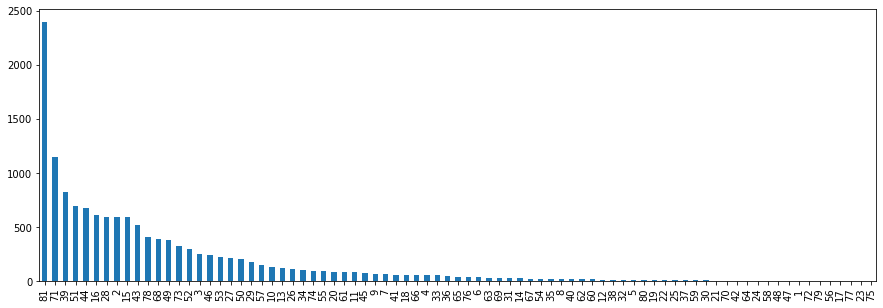

In [ ]:
plt.figure(figsize=(15, 5))
tmp_df = story_logs_df['category'].value_counts()
print(tmp_df.sort_values(ascending=False))
tmp_df.plot(kind='bar')

In [ ]:
party_x_socdem_path = f"{DATADIR}/avk_hackathon_data_party_x_socdem_nan2random.csv"
socdem_df = pd.read_csv(party_x_socdem_path)

In [ ]:
socdem_df.head()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,0,70.0,4,0,0
1,66535,0,25.0,3,0,0
2,83721,1,55.0,0,0,0
3,88238,0,35.0,1,0,0
4,57179,0,30.0,0,0,0


In [ ]:
def fill_marital(x):
    if x == 'Женат/замужем':
        return 0
    elif x == 'Вдовец, вдова':
        return 1
    elif x == 'Холост/не замужем':
        return 2
    elif x == 'Гражданский брак':
        return 3
    elif x == 'Разведен (а)':
        return 4
    elif x == 'Не проживает с супругом (ой)':
        return 5
    else:
        return np.random.randint(0, 6)

socdem_df['marital_status_desc'] = socdem_df['marital_status_desc'].apply(fill_marital)

In [ ]:
socdem_df.isna().sum()

party_rk                0
gender_cd              11
age                     0
marital_status_desc     0
children_cnt            0
region_flg              0
dtype: int64

In [ ]:
def fill_sex(x):
    if x == 'F':
        return 0
    elif x == 'M':
        return 1
    else:
        return np.random.randint(0, 2)

socdem_df['gender_cd'] = socdem_df['gender_cd'].apply(fill_sex)

In [ ]:
def encode_age(x):
    map_ = {float(a):i for i, a in enumerate(range(15, 105, 5))}
    return map_[x]

socdem_df['age'] = socdem_df['age'].apply(encode_age)

In [ ]:
socdem_df.head()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,0,11,4,0,0
1,66535,0,2,3,0,0
2,83721,1,8,0,0,0
3,88238,0,4,1,0,0
4,57179,0,3,0,0,0


In [ ]:
socdem_df.to_csv(f"{DATADIR}/avk_hackathon_data_party_x_socdem_encoded.csv", index=False)

In [ ]:
trans_socdem_df = transactions_df.merge(socdem_df, on='party_rk')

In [ ]:
trans_socdem_df.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,20337,19666,1,2019-01-01,Покупка,84.0,88676.0,348.0,NaN,Сувениры,0,2,0,0,0
1,20337,19666,1,2019-01-08,Покупка,865.0,1073466.0,297.0,404.0,Топливо,0,2,0,0,0
2,20337,19666,1,2019-01-03,Покупка,976.0,218889.0,336.0,930.0,Супермаркеты,0,2,0,0,0
3,20337,19666,1,2019-01-01,Покупка,2525.0,803379.0,401.0,NaN,Красота,0,2,0,0,0
4,20337,19666,1,2019-01-07,Покупка,1480.0,939775.0,378.0,NaN,Разные товары,0,2,0,0,0


In [ ]:
trans_socdem_df.shape, transactions_df.shape

((11987617, 15), (11987617, 10))

In [ ]:
trans_socdem_df.to_csv(f"{DATADIR}/avk_hackathon_data_trans_socdem_encoded.csv", index=False)

In [ ]:
trans_socdem_df = pd.read_csv(f"{DATADIR}/avk_hackathon_data_trans_socdem_encoded.csv")

NameError: ignored

In [ ]:
party_products_path = f"{DATADIR}/avk_hackathon_data_party_products.csv"
products_df = pd.read_csv(party_products_path)
products_df.head()

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


In [ ]:
trans_socdem_products_df = trans_socdem_df.merge(products_df, on='party_rk')

In [ ]:
print(trans_socdem_products_df.shape)
trans_socdem_products_df.head()

(11987617, 22)


,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category,gender_cd,age,marital_status_desc,children_cnt,region_flg,product1,product2,product3,product4,product5,product6,product7
0,20337,19666,1,2019-01-01,Покупка,84.0,88676.0,348.0,NaN,Сувениры,0,2,0,0,0,0,1,0,1,1,0,1
1,20337,19666,1,2019-01-08,Покупка,865.0,1073466.0,297.0,404.0,Топливо,0,2,0,0,0,0,1,0,1,1,0,1
2,20337,19666,1,2019-01-03,Покупка,976.0,218889.0,336.0,930.0,Супермаркеты,0,2,0,0,0,0,1,0,1,1,0,1
3,20337,19666,1,2019-01-01,Покупка,2525.0,803379.0,401.0,NaN,Красота,0,2,0,0,0,0,1,0,1,1,0,1
4,20337,19666,1,2019-01-07,Покупка,1480.0,939775.0,378.0,NaN,Разные товары,0,2,0,0,0,0,1,0,1,1,0,1


In [ ]:
trans_socdem_products_df.to_csv(f"{DATADIR}/avk_hackathon_data_trans_socdem_products_encoded.csv", index=False)

In [ ]:
trans_socdem_products_df = pd.read_csv(f"{DATADIR}/avk_hackathon_data_trans_socdem_products_encoded.csv")

In [ ]:
account_x_balance_path = f"{DATADIR}/avk_hackathon_data_account_x_balance.csv"
balance_df = pd.read_csv(account_x_balance_path)
balance_df = balance_df.drop_duplicates()
balance_df.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


In [ ]:
grouped_balance_df = balance_df.groupby(by=['party_rk', 'account_rk', 'cur_month']).sum()

In [ ]:
grouped_balance_df.to_csv(f"{DATADIR}/avk_hackathon_data_account_x_balance_grouped.csv", index=False)

In [ ]:
grouped_balance_df_tmp = grouped_balance_df.copy()
grouped_balance_df_tmp.index = grouped_balance_df_tmp.index.get_level_values('cur_month')
grouped_balance_df_tmp.head()

,balance_chng
cur_month,
2019-01-31,5000.0
2019-02-28,5000.0
2019-03-31,-10000.0
2019-04-30,5000.0
2019-05-31,0.0


In [ ]:
grouped_balance_df['cur_month'] = grouped_balance_df_tmp.index.map(
    lambda x: '-'.join((x.split('-'))[:-1])
)
grouped_balance_df['party_rk'] = grouped_balance_df.index.get_level_values('party_rk')
grouped_balance_df['account_rk'] = grouped_balance_df.index.get_level_values('account_rk')
grouped_balance_df.head(5)

balance_chng cur_month  party_rk  account_rk
party_rk account_rk cur_month                                               
1        2          2019-01-31        5000.0   2019-01         1           2
                    2019-02-28        5000.0   2019-02         1           2
                    2019-03-31      -10000.0   2019-03         1           2
                    2019-04-30        5000.0   2019-04         1           2
                    2019-05-31           0.0   2019-05         1           2

In [ ]:
grouped_balance_df.index = range(grouped_balance_df.shape[0])
grouped_balance_df.head()
grouped_balance_df['cur_month_dt'] = grouped_balance_df['cur_month'].apply(
    lambda x: datetime.strptime(x, '%Y-%m')
)
grouped_balance_df.head()

,balance_chng,cur_month,party_rk,account_rk,cur_month_dt
0,5000.0,2019-01,1,2,2019-01-01
1,5000.0,2019-02,1,2,2019-02-01
2,-10000.0,2019-03,1,2,2019-03-01
3,5000.0,2019-04,1,2,2019-04-01
4,0.0,2019-05,1,2,2019-05-01


In [ ]:
rks = trans_socdem_products_balance_df['party_rk'].to_numpy()
aks = trans_socdem_products_balance_df['account_rk'].to_numpy()
cur_months = trans_socdem_products_balance_df['cur_month'].to_numpy()

In [ ]:
def fill_mov_avg_balance_chng(rk, ak, cur_month, window_size=6):
    cur_month_dt = datetime.strptime(cur_month, '%Y-%m')

    sub_df = grouped_balance_df[ \
        (grouped_balance_df['party_rk'] == rk) \
        & (grouped_balance_df['account_rk'] == ak)
    ]
    # (grouped_balance_df['cur_month_dt'] <= cur_month_dt)
    sub_df = sub_df.sort_values('cur_month_dt')
    old_mean = sub_df['balance_chng'][:window_size].mean()
    sub_df = sub_df[sub_df['cur_month_dt'] <= cur_month_dt]
    sub_df = sub_df.sort_values('cur_month_dt')
    mean = sub_df['balance_chng'][-window_size:].mean()
    
    upd_mean = (mean + old_mean) / 2

    return upd_mean


mov_6_avg_balance_chng = []
for rk, ak, cur_month in tqdm(zip(rks, aks, cur_months), total=rks.shape[0]):
    mov_6_avg = fill_mov_avg_balance_chng(rk, ak, cur_month, 6)
    mov_6_avg_balance_chng.append(mov_6_avg)


# trans_socdem_products_balance_df['mov_6_avg_balance_chng'] = mov_6_avg_balance_chng

In [ ]:
def fill_balance_chg_sum(dttm):
    dttm = row['transaction_dttm']
    yyyy_mm = '-'.join(dttm.split('-'))
    return grouped_balance_df[grouped_balance_df['cur_month'] == yyyy_mm]['balance_chng']

In [ ]:
trans_socdem_products_df.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category,gender_cd,age,marital_status_desc,children_cnt,region_flg,product1,product2,product3,product4,product5,product6,product7
0,20337,19666,1,2019-01-01,Покупка,84.0,88676.0,348.0,NaN,Сувениры,0,2,0,0,0,0,1,0,1,1,0,1
1,20337,19666,1,2019-01-08,Покупка,865.0,1073466.0,297.0,404.0,Топливо,0,2,0,0,0,0,1,0,1,1,0,1
2,20337,19666,1,2019-01-03,Покупка,976.0,218889.0,336.0,930.0,Супермаркеты,0,2,0,0,0,0,1,0,1,1,0,1
3,20337,19666,1,2019-01-01,Покупка,2525.0,803379.0,401.0,NaN,Красота,0,2,0,0,0,0,1,0,1,1,0,1
4,20337,19666,1,2019-01-07,Покупка,1480.0,939775.0,378.0,NaN,Разные товары,0,2,0,0,0,0,1,0,1,1,0,1


In [ ]:
trans_socdem_products_df['cur_month'] = trans_socdem_products_df['transaction_dttm'].apply(
    lambda x: '-'.join((x.split('-'))[:-1])
)
trans_socdem_products_df.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category,gender_cd,age,marital_status_desc,children_cnt,region_flg,product1,product2,product3,product4,product5,product6,product7,cur_month
0,20337,19666,1,2019-01-01,Покупка,84.0,88676.0,348.0,NaN,Сувениры,0,2,0,0,0,0,1,0,1,1,0,1,2019-01
1,20337,19666,1,2019-01-08,Покупка,865.0,1073466.0,297.0,404.0,Топливо,0,2,0,0,0,0,1,0,1,1,0,1,2019-01
2,20337,19666,1,2019-01-03,Покупка,976.0,218889.0,336.0,930.0,Супермаркеты,0,2,0,0,0,0,1,0,1,1,0,1,2019-01
3,20337,19666,1,2019-01-01,Покупка,2525.0,803379.0,401.0,NaN,Красота,0,2,0,0,0,0,1,0,1,1,0,1,2019-01
4,20337,19666,1,2019-01-07,Покупка,1480.0,939775.0,378.0,NaN,Разные товары,0,2,0,0,0,0,1,0,1,1,0,1,2019-01


In [ ]:
trans_socdem_products_balance_df = trans_socdem_products_df.merge(grouped_balance_df, on=['party_rk', 'account_rk', 'cur_month'])

In [ ]:
trans_socdem_products_balance_df.to_csv(f"{DATADIR}/avk_hackathon_data_trans_socdem_products_balance_encoded.csv", index=False)

In [ ]:
trans_socdem_products_balance_df = pd.read_csv(f"{DATADIR}/avk_hackathon_data_trans_socdem_products_balance_encoded.csv")

In [ ]:
trans_socdem_products_balance_df.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category,gender_cd,age,marital_status_desc,children_cnt,region_flg,product1,product2,product3,product4,product5,product6,product7,cur_month,balance_chng
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры,0,2,0,0,0,0,1,0,1,1,0,1,2019-01,15000.0
1,56492,64272,1,2019-01-01,Покупка,101.00,1030137.0,372.0,NaN,Разные товары,1,5,0,0,0,0,1,0,0,0,0,0,2019-01,-10000.0
2,56492,64272,1,2019-01-01,Покупка,102.00,1030137.0,372.0,NaN,Разные товары,1,5,0,0,0,0,1,0,0,0,0,0,2019-01,-10000.0
3,56492,64272,1,2019-01-01,Покупка,606.65,533596.0,286.0,341.0,Супермаркеты,1,5,0,0,0,0,1,0,0,0,0,0,2019-01,-10000.0
4,18958,17865,2,2019-01-01,Покупка,111.00,482766.0,229.0,901.0,Транспорт,1,3,2,0,0,0,0,1,1,1,0,0,2019-01,-5000.0


In [ ]:
trans_socdem_products_balance_df = trans_socdem_products_balance_df.sort_values('transaction_dttm')

In [ ]:
trans_socdem_products_balance_df = trans_socdem_products_balance_df.reset_index(drop=True)

In [ ]:
trans_socdem_products_balance_df['children_cnt'].min()

0

In [ ]:
trans_socdem_products_balance_df.isna().sum()

party_rk                           0
account_rk                         0
financial_account_type_cd          0
transaction_dttm                   0
transaction_type_desc              0
transaction_amt_rur                5
merchant_rk                      976
merchant_type                   1437
merchant_group_rk            5938567
category                     1806940
gender_cd                          0
age                                0
marital_status_desc                0
children_cnt                       0
region_flg                         0
product1                           0
product2                           0
product3                           0
product4                           0
product5                           0
product6                           0
product7                           0
cur_month                          0
balance_chng                       0
dtype: int64

In [ ]:
del trans_socdem_products_balance_df

## Mappings
~1 min

In [18]:
# Prepare & save mappings
mappings = defaultdict(dict)
unk_token = "<UNK>"


def create_mapping(values):
    mapping = {unk_token: 0}
    for v in values:
        if not pd.isna(v):
            mapping[str(v)] = len(mapping)

    return mapping


for col in tqdm(
    [
        "transaction_type_desc",
        "merchant_rk",
        "merchant_type",
        "merchant_group_rk",
        "category",
        "financial_account_type_cd",
        'balance_chng'
    ]
):

    col_values = (
        pd.read_csv(transactions_enhanced_path, usecols=[col])[col]
        .fillna(unk_token)
        .astype(str)
    )
    mappings[col] = create_mapping(col_values.unique())
    del col_values


with open(f"{DATADIR}/mappings.json", "w") as f:
    json.dump(mappings, f)

In [ ]:
# load mappings
with open(f"{DATADIR}/mappings.json", 'r') as f:
    mappings = json.load(f)

## Parse transactions by users
~ 40 min

In [ ]:
# Prepare & save client data
# party2dates = defaultdict(list)  # for each party save a series of the transaction dates 
# party2sum = defaultdict(list)  # for each party save a series of the transaction costs 
# party2merchant_type = defaultdict(list)  # for each party save a series of the transaction_type 
# party2trans_type = defaultdict(list)  # for each party save a series of the transaction merchant_type
party2gender_cd = defaultdict(list) 
party2age = defaultdict(list)  
party2marital_status_desc = defaultdict(list)  
party2children_cnt = defaultdict(list)  
party2region_flg = defaultdict(list)  
party2product1 = defaultdict(list)  
party2product2 = defaultdict(list)  
party2product3 = defaultdict(list)
party2product4 = defaultdict(list)
party2product5 = defaultdict(list)
party2product6 = defaultdict(list)
party2product7 = defaultdict(list)
party2balance_chng = defaultdict(list)


usecols = [
    "party_rk",
    # "transaction_dttm",
    # "transaction_amt_rur",
    # "merchant_type",
    # "transaction_type_desc",
    'gender_cd',
    'age',
    'marital_status_desc',
    'children_cnt',
    'region_flg',
    'product1',
    'product2',
    'product3',
    'product4',
    'product5',
    'product6',
    'product7',
    'balance_chng'
]

for chunk in tqdm(
    pd.read_csv(transactions_enhanced_path, usecols=usecols, chunksize=100_000)
):

    # chunk["merchant_type"] = (
    #     chunk["merchant_type"].fillna(unk_token).astype(str)
    # )
    # chunk["transaction_type_desc"] = (
    #     chunk["transaction_type_desc"].fillna(unk_token).astype(str)
    # )
    # chunk["transaction_amt_rur"] = chunk["transaction_amt_rur"].fillna(0)


    for i, row in chunk.iterrows():
        party2gender_cd[row.party_rk].append(row.gender_cd)
        party2age[row.party_rk].append(row.age)
        party2marital_status_desc[row.party_rk].append(row.marital_status_desc)
        party2children_cnt[row.party_rk].append(row.children_cnt)
        party2region_flg[row.party_rk].append(row.region_flg)
        party2product1[row.party_rk].append(row.product1)
        party2product2[row.party_rk].append(row.product2)
        party2product3[row.party_rk].append(row.product3)
        party2product4[row.party_rk].append(row.product4)
        party2product5[row.party_rk].append(row.product5)
        party2product6[row.party_rk].append(row.product6)
        party2product7[row.party_rk].append(row.product7)
        party2balance_chng[row.party_rk].append(
            mappings["balance_chng"][str(row.balance_chng)]
        )


        # party2dates[row.party_rk].append(row.transaction_dttm)
        # party2sum[row.party_rk].append(row.transaction_amt_rur)
        # party2merchant_type[row.party_rk].append(
        #     mappings["merchant_type"][row.merchant_type]
        # )
        # party2trans_type[row.party_rk].append(
        #     mappings["transaction_type_desc"][row.transaction_type_desc]
        # )

    del chunk

# pickle.dump(party2dates, open(f"{DATADIR}/party2dates.pkl", "wb"))
# pickle.dump(party2sum, open(f"{DATADIR}/party2sum.pkl", "wb"))
# pickle.dump(party2merchant_type, open(f"{DATADIR}/party2merchant_type.pkl", "wb"))
# pickle.dump(party2trans_type, open(f"{DATADIR}/party2trans_type.pkl", "wb"))

pickle.dump(party2gender_cd, open(f"{DATADIR}/party2gender_cd.pkl", "wb"))
pickle.dump(party2age, open(f"{DATADIR}/party2age.pkl", "wb"))
pickle.dump(party2marital_status_desc, open(f"{DATADIR}/party2marital_status_desc.pkl", "wb"))
pickle.dump(party2children_cnt, open(f"{DATADIR}/party2children_cnt.pkl", "wb"))
pickle.dump(party2region_flg, open(f"{DATADIR}/party2region_flg.pkl", "wb"))
pickle.dump(party2product1, open(f"{DATADIR}/party2product1.pkl", "wb"))
pickle.dump(party2product2, open(f"{DATADIR}/party2product2.pkl", "wb"))
pickle.dump(party2product3, open(f"{DATADIR}/party2product3.pkl", "wb"))
pickle.dump(party2product4, open(f"{DATADIR}/party2product4.pkl", "wb"))
pickle.dump(party2product5, open(f"{DATADIR}/party2product5.pkl", "wb"))
pickle.dump(party2product6, open(f"{DATADIR}/party2product6.pkl", "wb"))
pickle.dump(party2product7, open(f"{DATADIR}/party2product7.pkl", "wb"))
pickle.dump(party2balance_chng, open(f"{DATADIR}/party2balance_chng.pkl", "wb"))

In [19]:
# load client data
party2dates = pickle.load(open(f"{DATADIR}/party2dates.pkl", 'rb'))
party2sum = pickle.load(open(f"{DATADIR}/party2sum.pkl", 'rb'))
party2merchant_type = pickle.load(open(f"{DATADIR}/party2merchant_type.pkl", 'rb'))
party2trans_type = pickle.load(open(f"{DATADIR}/party2trans_type.pkl", 'rb'))

# party2gender_cd = pickle.load(open(f"{DATADIR}/party2gender_cd.pkl", 'rb'))
# party2age = pickle.load(open(f"{DATADIR}/party2age.pkl", 'rb'))
party2marital_status_desc = pickle.load(open(f"{DATADIR}/party2marital_status_desc.pkl", 'rb'))
party2children_cnt = pickle.load(open(f"{DATADIR}/party2children_cnt.pkl", 'rb'))
# party2region_flg = pickle.load(open(f"{DATADIR}/party2region_flg.pkl", 'rb'))
# party2product1 = pickle.load(open(f"{DATADIR}/party2product1.pkl", 'rb'))
# party2product2 = pickle.load(open(f"{DATADIR}/party2product2.pkl", 'rb'))
# party2product3 = pickle.load(open(f"{DATADIR}/party2product3.pkl", 'rb'))
# party2product4 = pickle.load(open(f"{DATADIR}/party2product4.pkl", 'rb'))
# party2product5 = pickle.load(open(f"{DATADIR}/party2product5.pkl", 'rb'))
# party2product6 = pickle.load(open(f"{DATADIR}/party2product6.pkl", 'rb'))
# party2product7 = pickle.load(open(f"{DATADIR}/party2product7.pkl", 'rb'))
# party2balance_chng = pickle.load(open(f"{DATADIR}/party2balance_chng.pkl", 'rb'))

## PyTorch dataset

In [20]:
from sklearn.model_selection import train_test_split

train_party, valid_party = train_test_split(
    pd.read_csv(transactions_enhanced_path, usecols=['party_rk']).party_rk.unique(), 
    train_size=0.8, random_state=42
)

print(f'Train: {len(train_party)} Val: {len(valid_party)}')

Train: 39556 Val: 9889


In [21]:
predict_period_len = 60  # -- days
train_predict_dates = (
    pd.date_range("2019-03-01", "2019-10-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
valid_predict_dates = (
    pd.date_range("2019-11-01", "2019-12-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
submission_predict_dates = (
    pd.date_range("2020-01-01", "2020-02-28", freq="2MS")
    .strftime("%Y-%m-%d")
    .tolist()
)

In [22]:
print(train_predict_dates)
print(valid_predict_dates)
print(submission_predict_dates)

['2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01']
['2019-11-01', '2019-12-01']
['2020-01-01']


In [23]:
def prepare_data(party_list, mode="train"):
    """
    This function define the pipeline of the creation of train and valid samples.
    We consider each client from party_list. For each client take each 
    predict_period_start from predict_dates list. All client transaction before
    this date is our features. Next, we look at the customer's transactions in 
    the next two months. This transactions should be predicted. It will form 
    our labels vector.
    """

    data_sum = []
    data_trans_type = []
    data_merchant_type = []
    # data_gender_cd = []
    # data_age = []
    data_marital_status_desc = []
    data_children_cnt = []
    # data_region_flg = []
    # data_product1 = []
    # data_product2 = []
    # data_product3 = []
    # data_product4 = []
    # data_product5 = []
    # data_product6 = []
    # data_product7 = []
    # data_balance_chng = []
    data_labels = []

    for party_rk in tqdm(party_list):
        date_series = party2dates[party_rk]
        sum_series = party2sum[party_rk]
        merch_type_series = party2merchant_type[party_rk]
        trans_type_series = party2trans_type[party_rk]
        # gender_cd_series = party2gender_cd[party_rk]
        # age_series = party2age[party_rk]
        marital_status_desc_series = party2marital_status_desc[party_rk]
        children_cnt_series = party2children_cnt[party_rk]
        # region_flg_series = party2region_flg[party_rk]
        # product1_series = party2product1[party_rk]
        # product2_series = party2product2[party_rk]
        # product3_series = party2product3[party_rk]
        # product4_series = party2product4[party_rk]
        # product5_series = party2product5[party_rk]
        # product6_series = party2product6[party_rk]
        # product7_series = party2product7[party_rk]
        # balance_chng_series = party2balance_chng[party_rk]

        if mode == "train":
            predict_dates = train_predict_dates
        elif mode == "valid":
            predict_dates = valid_predict_dates
        elif mode == "submission":
            predict_dates = submission_predict_dates
        else:
            raise Exception("Unknown mode")

        for predict_period_start in predict_dates:

            predict_period_end = datetime.strftime(
                datetime.strptime(predict_period_start, "%Y-%m-%d")
                + timedelta(days=predict_period_len),
                "%Y-%m-%d",
            )

            l, r = (
                bisect_left(date_series, predict_period_start),
                bisect_right(date_series, predict_period_end),
            )

            history_merch_type = merch_type_series[:l]
            history_sum = sum_series[:l]
            history_trans_type = trans_type_series[:l]
            # history_gender_cd = gender_cd_series[:l]
            # history_age = age_series[:l]
            history_marital_status_desc = marital_status_desc_series[:l]
            history_children_cnt = children_cnt_series[:l]
            # history_region_flg = region_flg_series[:l]
            # history_product1 = product1_series[:l]
            # history_product2 = product2_series[:l]
            # history_product3 = product3_series[:l]
            # history_product4 = product4_series[:l]
            # history_product5 = product5_series[:l]
            # history_product6 = product6_series[:l]
            # history_product7 = product7_series[:l]
            # history_balance_chng = balance_chng_series[:l]
            predict_merch = merch_type_series[l:r]

            if predict_merch and l or mode not in ("train", "valid"):
                data_sum.append(history_sum)
                data_trans_type.append(history_trans_type)
                data_merchant_type.append(history_merch_type)
                # data_gender_cd.append(history_gender_cd)
                # data_age.append(history_age)
                data_marital_status_desc.append(history_marital_status_desc)
                data_children_cnt.append(history_children_cnt)
                # data_region_flg.append(history_region_flg)
                # data_product1.append(history_product1)
                # data_product2.append(history_product2)
                # data_product3.append(history_product3)
                # data_product4.append(history_product4)
                # data_product5.append(history_product5)
                # data_product6.append(history_product6)
                # data_product7.append(history_product7)
                # data_balance_chng.append(history_balance_chng)
                data_labels.append(predict_merch)

    return data_sum, data_trans_type, data_merchant_type, \
           data_marital_status_desc, data_children_cnt, \
           data_labels

In [24]:
train_sum, train_trans_type, train_merchant_type, \
train_marital_status_desc, train_children_cnt, \
train_labels = prepare_data(
    train_party, mode="train"
)
valid_sum, valid_trans_type, valid_merchant_type, \
valid_marital_status_desc, valid_children_cnt, \
valid_labels = prepare_data(
    valid_party, mode="valid"
)

## PyTorch loaders

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader

In [26]:
MERCH_TYPE_NCLASSES = len(mappings['merchant_type'])
TRANS_TYPE_NCLASSES = len(mappings['transaction_type_desc'])
# BALANCE_CHNG_NCLASSES = len(mappings['balance_chng'])
# GENDER_CD_NCLASSES = 2
# AGE_NCLASSES = 17
MARITAL_STATUS_DESC_NCLASSES = 6
CHILDREN_CNT_NCLASSES = 5
# REGION_FLG_NCLASSES = 2
# PRODUCTN_NCLASSES = 2
PADDING_LEN = 300

In [27]:
class RSDataset(Dataset):
    def __init__(self, data_sum, data_trans_type, data_merchant_type, 
                 data_marital_status_desc, 
                 data_children_cnt, labels):
        
        super(RSDataset, self).__init__()
        self.data_sum = data_sum
        self.data_trans_type = data_trans_type
        self.data_merchant_type = data_merchant_type
        self.data_marital_status_desc = data_marital_status_desc
        self.data_children_cnt = data_children_cnt
        self.labels = labels

    def __len__(self):
        return len(self.data_sum)

    def __getitem__(self, idx):
        # idx - индекс даты
        targets = np.zeros((MERCH_TYPE_NCLASSES - 1,), dtype=np.float32)
        for m in self.labels[idx]:
            # Смотрим лейблы по дате
            if m:  # skip UNK, UNK-token should not be predicted
                targets[m - 1] = 1.0

        item = {
            "features": {},
            "targets": targets,
        }

        sum_feature = np.array(self.data_sum[idx][-PADDING_LEN:])
        sum_feature = np.vectorize(lambda s: np.log(1 + s))(sum_feature)
        if sum_feature.shape[0] < PADDING_LEN:
            pad = np.zeros(
                (PADDING_LEN - sum_feature.shape[0],), dtype=np.float32
            )
            sum_feature = np.hstack((sum_feature, pad))
        item["features"]["sum"] = torch.from_numpy(sum_feature).float()

        for feature_name, feature_values in zip(
            [
                "trans_type", 
                "merchant_type", 
                # 'gender_cd',
                # 'age',
                'marital_status_desc',
                'children_cnt',
                # 'region_flg',
                # 'product1',
                # 'product2',
                # 'product3',
                # 'product4',
                # 'product5',
                # 'product6',
                # 'product7',
                # 'balance_chng'
            ],
            [
                self.data_trans_type[idx], 
                self.data_merchant_type[idx],
                # self.data_gender_cd[idx],
                # self.data_age[idx],
                self.data_marital_status_desc[idx],
                self.data_children_cnt[idx],
                # self.data_region_flg[idx],
                # self.data_product1[idx],
                # self.data_product2[idx],
                # self.data_product3[idx],
                # self.data_product4[idx],
                # self.data_product5[idx],
                # self.data_product6[idx],
                # self.data_product7[idx],
                # self.data_balance_chng[idx]
            ],
        ):

            feature_values = np.array(feature_values[-PADDING_LEN:])
            mask = np.ones(feature_values.shape[0], dtype=np.float32)
            if feature_values.shape[0] < PADDING_LEN:
                feature_values = np.append(
                    feature_values,
                    np.zeros(
                        PADDING_LEN - feature_values.shape[0], dtype=np.int64
                    ),
                )
                mask = np.append(
                    mask,
                    np.zeros(PADDING_LEN - mask.shape[0], dtype=np.float32),
                )
            item["features"][feature_name] = torch.from_numpy(feature_values).long()
            item["features"][f"{feature_name}_mask"] = torch.from_numpy(mask).float()

        return item

In [28]:
train_dataset = RSDataset(
    train_sum, train_trans_type, train_merchant_type,
    train_marital_status_desc, train_children_cnt,
    train_labels
)
valid_dataset = RSDataset(
    valid_sum, valid_trans_type, valid_merchant_type,
    valid_marital_status_desc, valid_children_cnt,
    valid_labels
)

In [29]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=2
)

In [ ]:
# sanity check
for i in tqdm(range(len(train_loader))):
    batch = next(iter(train_loader))
    break

print('\n', batch['features'].keys(), batch['features']['merchant_type'].shape)
batch['features']['merchant_type']

## Model

This is the baseline model for predicting purchases in `merchant_type` in the next 2 months

In [30]:
import torch.nn as nn
from collections import OrderedDict

In [31]:
params = {
    'merchant_type_emb_dim': 64,
    'trans_type_embedding': 4,
    # 'gender_cd_embedding': 2,
    # 'age_embedding': 12,
    'marital_status_desc_embedding': 4,
    'children_cnt_embedding': 3,
    # 'region_flg_embedding': 2,
    # 'productn_embedding': 2,
    # 'balance_chng_embedding': 5,
    'transformer_nhead': 2,
    'transformer_dim_feedforward': 256,
    'transformer_dropout': 0.1,
    'dense_unit': 256,
    'num_layers': 4,
}

In [ ]:
MERCH_TYPE_NCLASSES, TRANS_TYPE_NCLASSES

(454, 5)

In [33]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.merchant_type_embedding = nn.Embedding(
            MERCH_TYPE_NCLASSES, params["merchant_type_emb_dim"]
        )
        self.trans_type_embedding = nn.Embedding(
            TRANS_TYPE_NCLASSES, params["trans_type_embedding"]
        )
        self.marital_status_desc_embedding = nn.Embedding(
            MARITAL_STATUS_DESC_NCLASSES, params["marital_status_desc_embedding"]
        )
        self.children_cnt_embedding = nn.Embedding(
            CHILDREN_CNT_NCLASSES, params["children_cnt_embedding"]
        )


        embedding_size = (
            params["merchant_type_emb_dim"]
            + params["trans_type_embedding"]
            + params["marital_status_desc_embedding"]
            + params["children_cnt_embedding"]
            + 1
        )

        # print(embedding_size)
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_size,
            nhead=params["transformer_nhead"],
            dim_feedforward=params["transformer_dim_feedforward"],
            # dropout=params["transformer_dropout"],
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transformer_encoder_layer, 
            num_layers=params["num_layers"],
            norm=nn.LayerNorm(embedding_size)
        )

        self.linear = nn.Linear(
            in_features=embedding_size, out_features=params["dense_unit"]
        )
        self.scorer = nn.Linear(
            in_features=params["dense_unit"],
            out_features=MERCH_TYPE_NCLASSES - 1,
        )

    def forward(self, features):

        merchant_type_emb = self.merchant_type_embedding(features["merchant_type"])
        marital_status_desc_emb = self.marital_status_desc_embedding(features["marital_status_desc"])
        children_cnt_emb = self.children_cnt_embedding(features["children_cnt"])

        # print(features["merchant_type"].shape, merchant_type_emb.shape)
        trans_type_emb = self.trans_type_embedding(features["trans_type"])
        # print(features["trans_type"].shape, trans_type_emb.shape)

        merchant_type_emb = merchant_type_emb * features["merchant_type_mask"].unsqueeze(-1)
        trans_type_emb = trans_type_emb * features["trans_type_mask"].unsqueeze(-1)
        marital_status_desc_emb = marital_status_desc_emb * features["marital_status_desc_mask"].unsqueeze(-1)
        children_cnt_emb = children_cnt_emb * features["children_cnt_mask"].unsqueeze(-1)

        embeddings = torch.cat(
            (
                merchant_type_emb, 
                trans_type_emb, 
                marital_status_desc_emb,
                children_cnt_emb,
                features["sum"].unsqueeze(-1)
            ),
            dim=-1,
        )
        # print(features["sum"].shape, features["sum"].unsqueeze(-1).shape)
        # print(embeddings.shape)

        # print('TRANSFORMER PART:')
        transformer_output = self.transformer_encoder(embeddings)
        # print(transformer_output.shape)
        pooling = torch.mean(transformer_output, dim=1)
        # print(pooling.shape)
        linear = torch.tanh(self.linear(pooling))
        # print(linear.shape)
        merch_logits = self.scorer(linear)
        # print(merch_logits.shape)

        return merch_logits

### One-batch-check

In [ ]:
model = Model()
criterion = nn.BCEWithLogitsLoss()
batch = next(iter(train_loader))
output = model(batch['features'])
loss = criterion(output, batch['targets'])
print(loss)

tensor(0.6957, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [ ]:
batch['targets'].shape

torch.Size([64, 453])

In [ ]:
output[0]

tensor([-0.0067, -0.2120,  0.0116, -0.0854,  0.0082, -0.0168, -0.1258, -0.2237,
        -0.0111,  0.2479, -0.1773, -0.0124, -0.1828, -0.1453,  0.0160, -0.1982,
         0.1217, -0.3218,  0.1652, -0.2556,  0.3611,  0.1035,  0.0924,  0.1148,
        -0.2773,  0.2576,  0.2021, -0.3026, -0.0543, -0.3176, -0.2774, -0.0638,
        -0.1489,  0.0276, -0.2033,  0.2133,  0.3448,  0.0882,  0.0615,  0.3455,
        -0.1049, -0.1638, -0.0055,  0.2230,  0.1095, -0.1169,  0.0754, -0.0344,
         0.1450,  0.0787,  0.3001,  0.2015,  0.1889,  0.0075, -0.2656, -0.0890,
         0.1860,  0.0846, -0.0265, -0.1618, -0.0609,  0.1563,  0.2716, -0.1471,
        -0.1091, -0.1648, -0.1773,  0.1331, -0.1688,  0.0248, -0.3458,  0.0214,
         0.0470, -0.1893, -0.0244, -0.2109,  0.1232,  0.0730, -0.0513,  0.1378,
        -0.0018,  0.0640,  0.1742,  0.1349, -0.0971,  0.1747,  0.1185, -0.0045,
         0.0080,  0.3051,  0.1144, -0.0620, -0.0574, -0.1189, -0.1174,  0.0867,
        -0.1058, -0.1590, -0.2259, -0.23

## Train loop with [Catalyst](https://github.com/catalyst-team/catalyst)

[A comprehensive step-by-step guide to basic and advanced features](https://github.com/catalyst-team/catalyst#step-by-step-guide).

---



In [34]:
from catalyst import dl, utils
from catalyst.utils import metrics

## Custom metrics for this hackathon

In [35]:
from typing import List, Optional, Sequence, Tuple, Union

import numpy as np
import torch
from catalyst.utils.metrics.functional import preprocess_multi_label_metrics
from catalyst.utils.torch import get_activation_fn


def multi_label_metrics(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    threshold: Union[float, torch.Tensor],
    activation: Optional[str] = None,
    eps: float = 1e-7,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes multi-label precision for the specified activation and threshold.

    Args:
        outputs (torch.Tensor): NxK tensor that for each of the N examples
            indicates the probability of the example belonging to each of
            the K classes, according to the model.
        targets (torch.Tensor): binary NxK tensort that encodes which of the K
            classes are associated with the N-th input
            (eg: a row [0, 1, 0, 1] indicates that the example is
            associated with classes 2 and 4)
        threshold (float): threshold for for model output
        activation (str): activation to use for model output
        eps (float): epsilon to avoid zero division
    
    Extended version of 
        https://github.com/catalyst-team/catalyst/blob/master/catalyst/utils/metrics/accuracy.py#L58

    Returns:
        computed multi-label metrics
    """
    outputs, targets, _ = preprocess_multi_label_metrics(
        outputs=outputs, targets=targets
    )
    activation_fn = get_activation_fn(activation)
    outputs = activation_fn(outputs)

    outputs = (outputs > threshold).long()

    accuracy = (targets.long() == outputs.long()).sum().float() / np.prod(
        targets.shape
    )

    intersection = (outputs.long() * targets.long()).sum(axis=1).float()
    num_predicted = outputs.long().sum(axis=1).float()
    num_relevant = targets.long().sum(axis=1).float()
    union = num_predicted + num_relevant

    # Precision = ({predicted items} && {relevant items}) / {predicted items}
    precision = intersection / (num_predicted + eps * (num_predicted == 0))
    # Recall = ({predicted items} && {relevant items}) / {relevant items}
    recall = intersection / (num_relevant + eps * (num_relevant == 0))
    # IoU = ({predicted items} && {relevant items}) / ({predicted items} || {relevant items})
    iou = (intersection + eps * (union == 0)) / (union - intersection + eps)

    return accuracy, precision.mean(), recall.mean(), iou.mean()


def precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
):
    """
    Computes precision at cutoff k for one sample

    Args:
       actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
       predicted (torch.Tensor): binary tensor that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       k (int): parameter k of precison@k

    Returns:
       Computed value of precision@k for given sample
    """
    p_at_k = 0.0
    for item in predicted[:k]:
        if actual[item]:
            p_at_k += 1
    p_at_k /= k

    return p_at_k


def average_precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
) -> float:
    """
    Computes average precision at cutoff k for one sample

    Args:
      actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
      predicted (torch.Tensor): binary tensor that encodes which of the K
          classes are associated with the N-th input
          (eg: a row [0, 1, 0, 1] indicates that the example is
          associated with classes 2 and 4)
      k (int): parameter k of AP@k

    Returns:
        Computed value of AP@k for given sample
    """
    ap_at_k = 0.0
    for idx, item in enumerate(predicted[:k]):
        if actual[item]:
            ap_at_k += precision_at_k(actual, predicted, k=idx + 1)
    ap_at_k /= min(k, actual.sum().cpu().numpy())
    

    return ap_at_k


def mean_average_precision_at_k(
    output: torch.Tensor, target: torch.Tensor, top_k: Tuple[int, ...] = (1,)
) -> List[float]:
    """
    Computes mean_average_precision_at_k at set of cutoff parameters K

    Args:
       outputs (torch.Tensor): NxK tensor that for each of the N examples
           indicates the probability of the example belonging to each of
           the K classes, according to the model.
       targets (torch.Tensor): binary NxK tensort that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       top_k (tuple): list of parameters k at which map@k will be computed


    Returns:
       List of computed values of map@k at each cutoff k from topk
    """
    max_k = max(top_k)
    batch_size = target.size(0)

    _, top_indices = output.topk(k=max_k, dim=1, largest=True, sorted=True)

    result = []
    for k in top_k:  # loop over k
        map_at_k = 0.0
        for actual_target, predicted_items in zip(
            target, top_indices
        ):  # loop over samples
            map_at_k += average_precision_at_k(
                actual_target, predicted_items, k
            )
        map_at_k = map_at_k / batch_size
        result.append(map_at_k)

    return result

In [36]:
# What is Runner?
# https://catalyst-team.github.io/catalyst/api/core.html#runner
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch["features"], batch["targets"]
        logits = self.model(features)
        scores = torch.sigmoid(logits)

        loss = self.criterion(logits, targets)
        accuracy, precision, recall, iou = multi_label_metrics(
            logits, targets, threshold=0.5, activation="Sigmoid"
        )
        map05, map10, map20 = mean_average_precision_at_k(
            scores, targets, top_k=(5, 10, 20)
        )
        batch_metrics = {
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "iou": iou,
            "map05": map05,
            "map10": map10,
            "map20": map20
        }
        
        self.input = {"features": features, "targets": targets}
        self.output = {"logits": logits, "scores": scores}
        self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def predict_batch(self, batch):
        # model inference step
        batch = utils.maybe_recursive_call(batch, "to", device=self.device)
        logits = self.model(batch["features"])
        scores = torch.sigmoid(logits)
        return scores

In [37]:
model = Model()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loaders = {"train": train_loader, "valid": valid_loader}

In [38]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 742), started 1:17:04 ago. (Use '!kill 742' to kill it.)

<IPython.core.display.Javascript object>

In [39]:
# For other minimal examples, please follow the link below
# https://github.com/catalyst-team/catalyst#minimal-examples
runner = CustomRunner()
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    loaders=loaders,
    logdir="./logs",
    num_epochs=10,
    verbose=True,
    load_best_on_end=True,
    overfit=False,  #  <<<--- DO NOT FORGET TO MAKE IT ``False`` 
                    #  (``True`` uses only one batch to check pipeline correctness)
    callbacks=[
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
        # dl.AveragePrecisionCallback(input_key="targets", output_key="scores", prefix="ap"),
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
        # dl.AUCCallback(input_key="targets", output_key="scores", prefix="auc"),
    ],
    main_metric="iou", # "ap/mean", 
    minimize_metric=False,
)

1/10 * Epoch (train): 100% 3807/3807 [21:17<00:00,  2.98it/s, accuracy=0.982, iou=0.274, loss=0.055, map05=0.691, map10=0.617, map20=0.596, precision=0.740, recall=0.358]
1/10 * Epoch (valid):  25% 68/269 [00:18<00:55,  3.62it/s, accuracy=0.980, iou=0.261, loss=0.059, map05=0.585, map10=0.533, map20=0.503, precision=0.623, recall=0.364]

IndexError: ignored

In [ ]:
# model inference example
# for prediction in runner.predict_loader(loader=loaders["valid"]):
#     assert prediction.detach().cpu().numpy().shape[-1] == MERCH_TYPE_NCLASSES-1

In [ ]:
# import plotly  # required for contrib
# from catalyst.contrib.utils import plot_tensorboard_log

# plot_tensorboard_log(logdir="./logs", step="batch")

In [ ]:
import plotly  # required for contrib
from catalyst.contrib.utils import plot_tensorboard_log

plot_tensorboard_log(
    logdir="./logs", 
    step="epoch", 
    metrics=[
        "loss", "accuracy", "precision", "recall", "iou", 
        "map05", "map10", "map20",
        "ap/mean", "auc/mean"
    ]
)

## Your task

We suggest you to improve this baseline. Feel free to use any kind of model architectures, loss functions, inputs, etc. in your experiments.


YOUR TASK is to predict purchases in `merchant_type` in **January-February 2020** for all the clients (50k) from the given dataset.

SUBMISSION FORMAT: You should submit a `.csv` file in the following format. 

The submission file should contain two columns:
* `party_rk` -- client unique identifier
* `recommendations` -- list of the **top 30** predicted `merchant_type`, sorted by predicted proba (pay attention!) **separated by commas**. 

The `.csv` file separator should be **semicolon (";")**. The submission file example can be generated by the pipeline shown below.

EVALUATION: Your submission will be evaluated by metric **MAP@30**. Scores for this part of the hackathon will be given according to the value of this metric.

Good luck!

## Submission file example

In [ ]:
# create data loader for submission
full_party = pd.read_csv(transactions_enhanced_path, usecols=['party_rk']).party_rk.unique()

full_sum, full_trans_type, full_merchant_type, \
full_marital_status_desc, full_children_cnt, \
full_labels = prepare_data(
    full_party, mode="submission"
)
full_dataset = RSDataset(
   full_sum, full_trans_type, full_merchant_type, full_marital_status_desc, full_children_cnt, full_labels
)
full_loader = DataLoader(
    full_dataset, batch_size=64, shuffle=False, num_workers=8, drop_last=False)

In [ ]:
# get predictions from the model
predictions = []
for scores in tqdm(runner.predict_loader(loader=full_loader), total = len(full_loader)):
    _, top_indices = scores.topk(k=30, dim=1, largest=True, sorted=True)
    top_indices += 1
    predictions += top_indices.detach().cpu().tolist()

In [ ]:
# inverse mapping for merchant_type in predictions
merchant_type_inverse_mapping = {k: v for v, k in mappings['merchant_type'].items()}
def inverse_mapping(x):
    return list(map(merchant_type_inverse_mapping.get, x))

predictions = list(map(inverse_mapping, predictions))

In [ ]:
# create submission table
submission = pd.DataFrame({
    "party_rk" : full_party, 
    "recommendations" : predictions
})
submission['recommendations'] = submission['recommendations'].apply(lambda x: ",".join(map(str, x)))

submission.to_csv(r'submission_T^2.csv', index=False, sep=";")